*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur and updated by Ross Beveridge.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/fall23/notebooks/module01_06_perceptron.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Linear Models for Classification: The Perceptron


### A review of labeled data

**Definition.** A labeled dataset is a collection of feature vectors and their associated labels:

$$
\mathcal{D} = \{ \;(\mathbf{x}_i, y_i) \; \}_{i=1}^N
$$

where $\mathbf{x}_i \in \mathbb{R}^d$ and $y_i$ is the label associated with $\mathbf{x}_i$.
(Recall that $\mathbb{R}^d$ is the set of all $d$-dimensional vectors with entries that are real numbers).  When dealing with classification problems, the labels belong to a set of discrete options, which is the set of classes that an object can belong to.

In this notebook we will focus on binary classification problems where  each example is classified into one of two classes.  Here we will use the labels $\{ -1, 1 \}$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4)

First, let's create some data:

In [2]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=100, n_features=2, n_informative=2, 
                          n_redundant=0, n_repeated=0, n_classes=2, 
                          n_clusters_per_class=1, class_sep=0.6, random_state=1)
X.shape, y.shape

((100, 2), (100,))

As the plot below shows, this data is **linearly separable**:  there exists a hyperplane defined by a weight vector and bias $(\mathbf{w}, b)$ that correctly classifies each data point in it.  That means, that for that separating hyperplane, all of the positive examples fall on one side and the negative examples on the other side.  Since this data is two dimensional, the hyperplane in this case is a line.

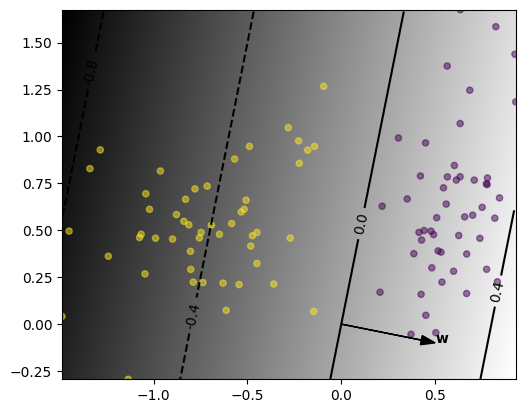

In [3]:
plt.style.use('default')
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.5, s=20, cmap='viridis');

w = np.array([0.5, -0.1])
b = 0
delta = 0.01
xmin=np.min(X[:,0]);xmax=np.max(X[:,0]);ymin=np.min(X[:,1]);ymax=np.max(X[:,1])
xs = np.arange(xmin, xmax, delta)
ys = np.arange(ymin, ymax, delta)
x_grid, y_grid = np.meshgrid(xs, ys)

Z = w[0] * x_grid + w[1] * y_grid + b
    
im = plt.imshow(Z, origin='lower',
                cmap=plt.cm.gray, extent=(xmin,xmax,ymin,ymax) )

C = plt.contour(x_grid, y_grid, Z, 3, origin='lower',
                colors = 'black')

plt.clabel(C, fmt='%1.1f')

plt.arrow(0,0,w[0],w[1], width=0.001,head_width=0.05, length_includes_head=True, alpha=1,linestyle='-',color='k');
plt.text(w[0], w[1], r"$\mathbf{w}$");


While not all datasets are linearly separable, we will start by considering algorithms designed to solve this simpler class of problems.
Also, we will focus on hyperplanes that go through the origin, i.e. $b=0$.

## The Perceptron Algorithm

The perceptron algorithms is a training algorithm that finds a value for the hyperplane that separates the two classes of examples.
This algorithm, proposed in 1958 by Frank Rosenblatt, is one of the first machine learning algorithms.  It is also the precursor of neural networks.

**Idea:** iterate over the training examples, and update the weight vector $\mathbf{w}$ in a way that will make each training example $\mathbf{x}_i$  more likely to be correctly classified.

### Case 1: Misclassified Positive Example 

Let's assume $\mathbf{x}_i$ is a positive example that is incorrectly classified, i.e. $\mathbf{w}^\top \mathbf{x}_i < 0$.

Let's consider the update equation

$$
\mathbf{w}' = \mathbf{w} + \eta \mathbf{x}_i,
$$

where $1 > \eta > 0$ is a (small) positive number called the *learning rate*.

As we are about to show that the following is true:

$$
\mathbf{w}'^\top \mathbf{x}_i > \mathbf{w}^\top \mathbf{x}_i.
$$

This has the desired effect making $\mathbf{x}_i$ be more likely to be correctly classified.  This happens because the dot product of $\mathbf{x}_i$ with the weight vector is less likely to be negative after the update.

And indeed:

$$
\mathbf{w}'^\top \mathbf{x}_i = 
(\mathbf{w} + \eta \mathbf{x}_i)^\top  \mathbf{x}_i = 
\mathbf{w}^\top \mathbf{x}_i + \eta \mathbf{x}_i^\top  \mathbf{x}_i > \mathbf{w}^\top \mathbf{x}_i
$$

The derivation hinges upon the fact that for any non-zero vector $\mathbf{x}^\top \mathbf{x} > 0$.


#### A few more details

In deriving this inequality we relied on the following properties of the dot product:

* For any non-zero vector $\mathbf{x}$, we have that $\mathbf{x}^\top \mathbf{x} > 0$.
* For any vectors $\mathbf{u}, \mathbf{v}, \mathbf{w}$, we have that $(\mathbf{u} + \mathbf{v})^\top \mathbf{w} = \mathbf{u}^\top \mathbf{w} + \mathbf{v}^\top \mathbf{w}$

Using the definition of the dot product, verify that these properties hold.

### Case 2: A Misclassified Negative Example

If $\mathbf{x}_i$ is a negative example, the update needs to be in the opposite direction, since we want to make the dot product $\mathbf{w}^\top\mathbf{x}$ more negative.

Recall now that $y_i$ will be $-1$ in this case, so the following will change the sign of our previous update equation

$$
\mathbf{w}' = \mathbf{w} - \eta \mathbf{x}_i = \mathbf{w} + y_i \eta \mathbf{x}_i 
$$

Overall, we can summarize both cases using the following equation:

$$
\mathbf{w}' = \mathbf{w} + y_i \eta \mathbf{x}_i
$$

This leads us to the following algorithm:

`The perceptron algorithm`

**input:**  a labeled dataset

**output:** a weight vector $\mathbf{w}$.

```
initialize w=0
converged = False
while not converged :
    converged = True
    for i in 1,...,N :
        if x_i is misclassified update w and set
            converged=False
return w
```

Each iteration over the entire dataset is called an **epoch**.

Below we will create a Python class that implements this algorithm.

But first, let's write a function that generates linearly separable data in two dimensions:

In [4]:
def generate_separable_data(N, seed=1) :
    epsilon = 0.05
    rng = np.random.default_rng(seed)
    w = rng.uniform(-1 , 1, 2)
    X = rng.uniform(-1 + epsilon, 1 - epsilon, [N, 2])
    y = np.sign(np.dot(X, w))
    # note:  the sign function returns a +1 or -1 depending on the sign
    # of its argument
    return X,y,w

In [5]:
X, y, w = generate_separable_data(10)
X.shape

(10, 2)

The following is a function to display the data and the weight vector:

In [6]:
def plot_data(X, y, w) :
    fig = plt.figure(figsize=(4,4))
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.arrow(0,0,w[0],w[1], width=0.001,head_width=0.05, 
              length_includes_head=True, alpha=1,
              linestyle='-',color='purple')
    a = -w[0]/w[1] # Slope of the line through origin
    pts = np.linspace(-1,1)
    plt.plot(pts, a*pts, 'k-')
    cols = {1: 'b', -1: 'r'}
    for i in range(len(X)): 
        plt.plot(X[i][0], X[i][1], cols[y[i]]+'o', alpha=0.6) 

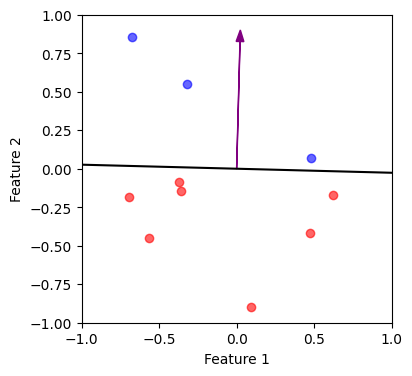

In [7]:
X,y,w = generate_separable_data(10)
plot_data(X, y, w)

And here's the Python class with the implementation of the perceptron:

In [8]:
class perceptron :
    """An implementation of the perceptron algorithm.
    Note that this implementation does not include a bias term"""
 
    def __init__(self, iterations=100, learning_rate=0.2, 
                 plot_data=False, random_w=False, seed=42) :
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.plot_data = plot_data
        self.random_w = random_w
        self.seed = seed
  
    def fit(self, X, y) :
        """
        Train a classifier using the perceptron training algorithm.
        After training the attribute 'w' will contain the perceptron weight vector.
 
        Parameters
        ----------
 
        X : ndarray, shape (num_examples, n_features)
        Training data.
 
        y : ndarray, shape (n_examples,)
        Array of labels.
 
        """
        
        if self.random_w :
            rng = np.random.default_rng(self.seed)
            self.w = rng.uniform(-1 , 1, len(X[0]))
            print("initialized with random weight vector")
        else :
            self.w = np.zeros(len(X[0]))
            print("initialized with a zeros weight vector")
        self.wold = self.w
        converged = False
        iteration = 0
        while (not converged and iteration <= self.iterations) :
            converged = True
            for i in range(len(X)) :
                if y[i] * self.decision_function(X[i]) <= 0 :
                    self.wold = self.w
                    self.w = self.w + y[i] * self.learning_rate * X[i]
                    converged = False
                    if self.plot_data:
                        self.plot_update(X, y, i)
            iteration += 1
        self.converged = converged
        if converged :
            print ('converged in %d iterations ' % iteration)
 
    def decision_function(self, x) :
        return np.dot(x, self.w)
 
    def predict(self, X) :
        """
        make predictions using a trained linear classifier
 
        Parameters
        ----------
 
        X : ndarray, shape (num_examples, n_features)
        Training data.
        """
 
        scores = np.dot(X, self.w)
        return np.sign(scores)
    
    def plot_update(self, X, y, ipt) :
        fig = plt.figure(figsize=(4,4))
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.arrow(0,0,self.w[0],self.w[1], 
                  width=0.001,head_width=0.05, 
                  length_includes_head=True, alpha=1,
                  linestyle='-',color='darkred')
        plt.arrow(0,0,self.wold[0],self.wold[1], 
                  width=0.001,head_width=0.05, 
                  length_includes_head=True, alpha=1,
                  linestyle='-',color='orange')
        anew = -self.w[0]/self.w[1]
        aold = -self.wold[0]/self.wold[1]
        pts = np.linspace(-1,1)
        plt.plot(pts, anew*pts, color='darkred')
        plt.plot(pts, aold*pts, color='orange')
        plt.title("in orange:  old w; in red:  new w")
        cols = {1: 'g', -1: 'b'}
        for i in range(len(X)): 
            plt.plot(X[i][0], X[i][1], cols[y[i]]+'o', alpha=0.6,markersize=5) 
        plt.plot(X[ipt][0], X[ipt][1], 'ro', alpha=0.2,markersize=20)
 

initialized with a zeros weight vector


C:\Users\Relax\AppData\Local\Temp\ipykernel_5060\1209631638.py:85: RuntimeWarning: invalid value encountered in scalar divide
  aold = -self.wold[0]/self.wold[1]


converged in 5 iterations 


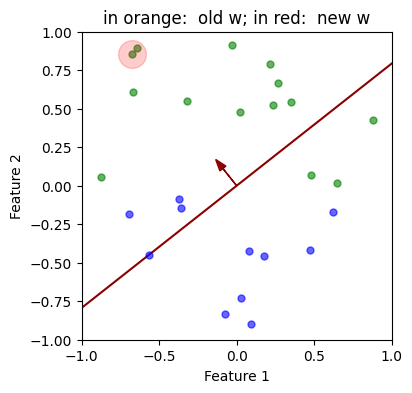

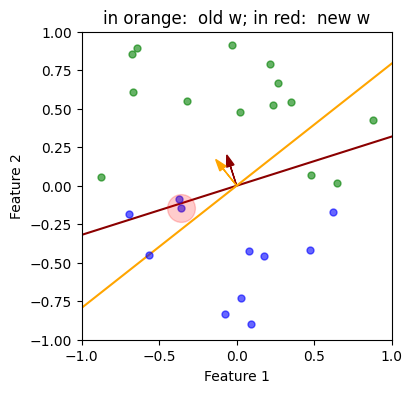

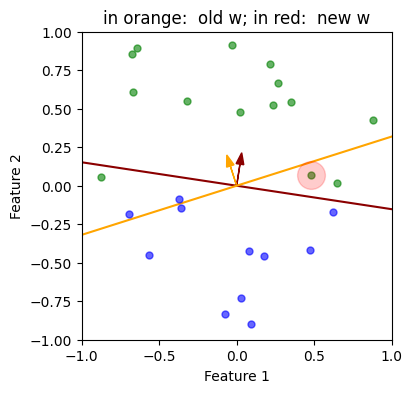

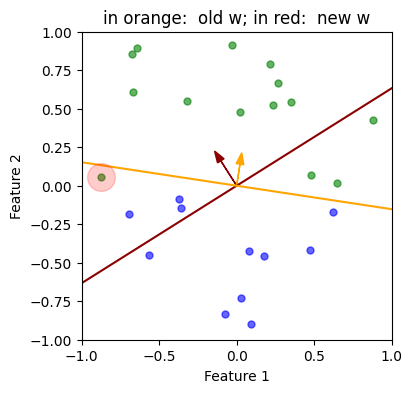

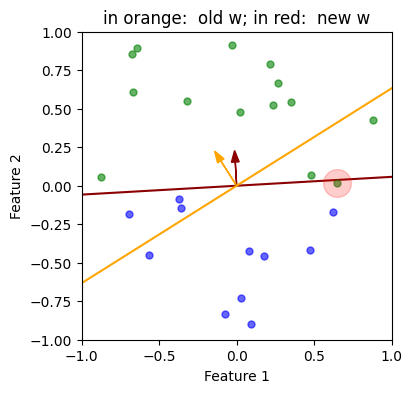

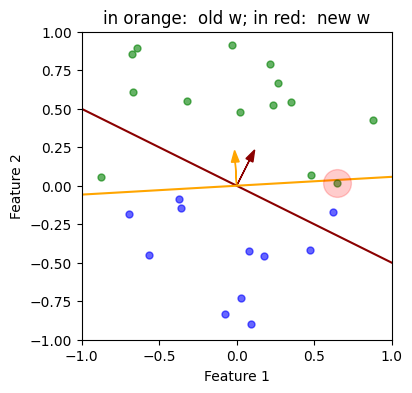

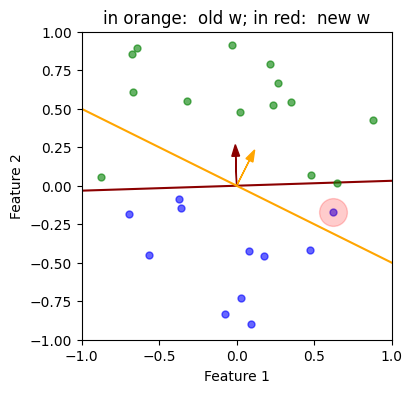

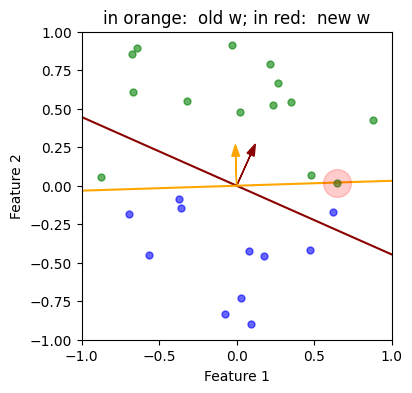

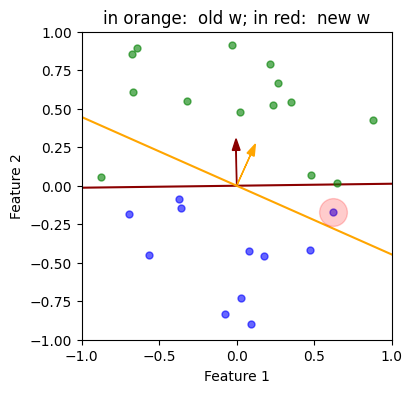

In [9]:
X,y,w = generate_separable_data(25)
p = perceptron(plot_data=True)
p.fit(X,y)

initialized with random weight vector
converged in 3 iterations 


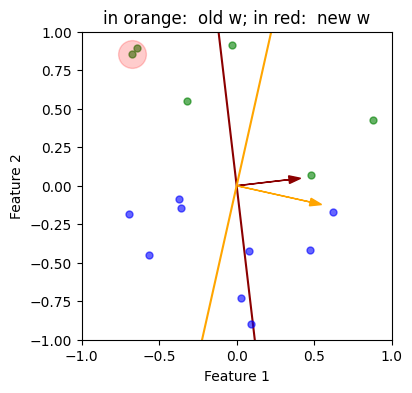

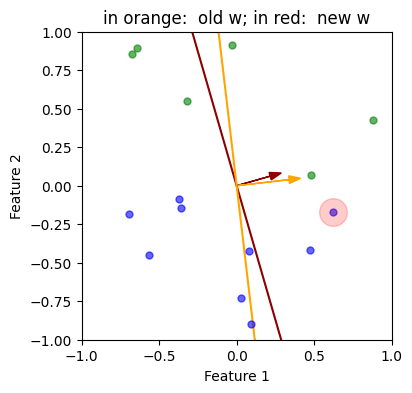

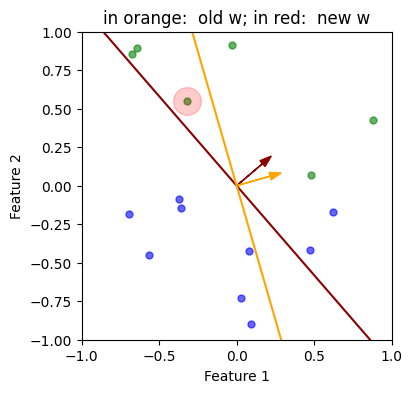

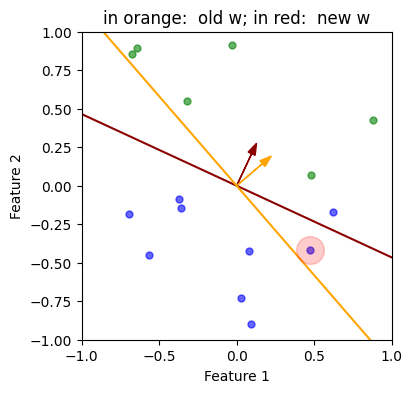

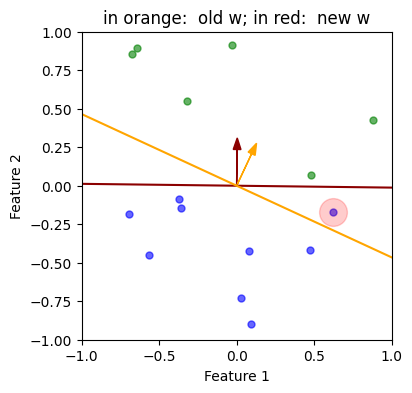

In [10]:
X,y,w = generate_separable_data(15)
p = perceptron(random_w = True, plot_data=True)
p.fit(X,y)

### Experiment With Different Problem Instances

Use the code above to repeatedly look at how the decision boundary changes.  To explain what you are seeing, the code plots the decision boundary before and after an update.  The specific point generating the update is shown with a red halo. Keep in mind this point was found to fall on the wrong side of the decision boundary and the boundary is adjusted to hopefully have it fall on the correct side.

### About the Learned Decision Boundary

Let's compare the original weight vector that defined the class boundary to the weight vector learned by the perceptron:

In [11]:
p.w, w

(array([0.0038, 0.3103]), array([0.0236, 0.9009]))

It may be hard to tell if these are similar. Next, let's normalize the two vectors into unit vectors:

In [12]:
print(p.w/np.sqrt(np.dot(p.w, p.w)))
print(w/np.sqrt(np.dot(w, w)))

[0.0122 0.9999]
[0.0262 0.9997]


Now we can see that they are pointing more or less in the same direction!

## Adding a Bias Term

The perceptron algorithm as stated above has some limitations:

* The hyperplane goes through the origin.
* The algorithm doesn't converge if the data is not linearly separable.

We addressed the second limitation by adding a limit on the number of iterations.
To address the first, we'll show a trick for introducing a bias without actually having to modify the algorithm.  To do so, we'll modify the data instead.

Let's add another dimension to our weight vector, and a constant feature to our data:

$\tilde{\mathbf{w}}=[w_1,\ldots,w_d,w_{d+1}]^\top$

$\tilde{\mathbf{x}}= [x_1,\ldots,x_d,1]^\top$

With these definitions, you can easily verify that 

$$
\tilde{\mathbf{w}}^\top \tilde{\mathbf{x}} = \mathbf{w}^\top \mathbf{x}
+ w_{d+1}
$$

i.e. $w_{d+1}$ is equivalent to the bias term.

In view of this discussion, to implement a bias term all we need to do is add a column of ones to our feature matrix.
An alternative is to formulate the perceptron algorithm with a bias term, which is also quite simple.

### The perceptron algorithm applied to the Wisconsin breast cancer dataset

To demonstrate that the perceptron algorithm can solve real-world problems we will apply it to a well known dataset to the diagnosis of breast cancer.
The Wisconsin breast cancer is one of the scikit-learn built in datasets.  It is available from the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)), which is one of the earliest web resources for machine learning datasets.

The dataset quantifies cancerous breast tissue, and the task is to try and distinguish between benign and malignant cancer.  The features were computed from images of tissue biopsies.

In [13]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

A scikit-learn data object is container with the following attributes: 
  * ‘data’, the feature matrix
  * ‘target’, the labels (as integers)
  * ‘target_names’, the names of the classes
  * ‘feature_names’, the names of the features
  * ‘DESCR’, a description of the dataset.


In [14]:
X = data.data
y = data.target
print('number of examples ', len(y))
print('number of features ', len(X[0]))

print('labels: ', data.target_names)
print('features: ', data.feature_names)

number of examples  569
number of features  30
labels:  ['malignant' 'benign']
features:  ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


Alternatively, we can directly load the feature matrix and labels:

In [15]:
from sklearn.datasets import load_breast_cancer
X,y = data = load_breast_cancer(return_X_y = True)
X.shape, y.shape

((569, 30), (569,))

In [16]:
y[:25]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0])

What does the following transformation do, and why do we need to do it?  (Hint:  what are the values in the vector y, and what does our code expect?)

In [17]:
y = y * 2 - 1

In view of our discussion above, to implement a bias term all we need to do is add a column of ones to our feature matrix:

In [18]:
X = np.hstack([X, np.ones((len(X), 1))])
X.shape

(569, 31)

Next, we will split the data into separate **training set** and **test set**.  Discuss why we do that!

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=5)

Now we are ready to train and evaluate the perceptron (note we are training on the training set, and evaluating on the test set):

In [20]:
p = perceptron(iterations = 500, learning_rate = 0.1)
p.fit(X_train, y_train)
y_pred = p.predict(X_test)
print('accuracy: ', np.mean(y_test == y_pred))

initialized with a zeros weight vector


accuracy:  0.8421052631578947


For comparison let's evaluate the perceptron on the training set:

In [21]:
y_pred = p.predict(X_train)
print('accuracy: ', np.mean(y_train == y_pred))

accuracy:  0.8291457286432161


Surprised?  Why is that?

Now let's run the perceptron multiple times with different initializations of the weight vector.  Do you always get the same result?

In [22]:
# run the perceptron algorithm multiple times

### Digression:  machine learning repositories

The availability of web-accessible datasets that can be readily analyzed has been a driving force in the development of machine learning.  The [UCI machine learning repository](https://archive.ics.uci.edu/ml/index.php) has been one of the early sources, and the datasets available from it have been widely used for benchmarking in the  machine learning literature.  The rapid growth in the number of machine learning practitioners has led to development of resources such as [Kaggle](https://www.kaggle.com), which allows for people to test their skills in machine learning competitions that are posted on a regular basis.  [Open ML](https://www.openml.org), is also a good resource (see also their [list of useful ML repositories](https://docs.openml.org/Data-Repositories/).  Given their interest in ML, it's not surprising that Google has a specific tool for [dataset search](https://datasetsearch.research.google.com/).


### Exercises

* Explore the accuracy of the perceptron on the breast cancer dataset while varying the number of epochs that the perceptron is trained.  Measure accuracy on both the training and test sets.  What can you conclude?

* Can you tell if the dataset is linearly separable?

* Do you observe differences in performance by changing the learning rate?


In [23]:
# your code here

## About Train / Test Splits

After completing these exercises we can talk about what is quite likely the most important issue in machine learning - **generalization**.  This is the ability of your classifier to perform well on an unseen test set.  That is why in our experiment with the Wisconsin breast cancer dataset we split our data into a training set and a test set.
The **training set** is used to learn from the data, while the **test set** is used to evaluate how well the classifier is doing on new unseen data (generalization).

To meaningfully discuss generalization to new samples there are a couple of nomenclature hurdles we need to overcome.  With this in mind, let us discussed the following terms:

* **Dataset** - the collection of examples that are used to construct our training and test sets.  We assume there is some hidden process that is providing us the data, but all we have the concrete sample from the distribution.
* **Random sampling** - the process by which we obtained our dataset and chose to split it into train/test sets.  The underlying assumption in much of machine learning is that our examples are [identically and independently distributed](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) (i.i.d).  This is a standard assumption that simplifies the math, and evaluation of performance.

Last but not least, perhaps the most important and hardest issue is simply this - when confronting a real world problem where the goal is to make predictions (use machine learning), what evidence is there for the underlying assumption that our performance evaluation is indicative of what we would obtain in real-world usage?

You may also find the following resource useful:  

* [Google Developers Lecture on Generalization](https://developers.google.com/machine-learning/crash-course/generalization/video-lecture)

### Pros and cons of the perceptron

Here are some points in favor and against the perceptron:

####  Pros 

* Simple and easy to implement
* Relatively fast to train

#### Cons

Even with the fixes we made to the perceptron, there are still a couple of issues with the algorithm:

* The algorithm contains several *hyperparameters*:  the number of epochs, and learning rate.  It is not clear how to set those parameters.
* The solution bounces around and the algorithm chooses an arbitrary hyperplane that separates the two classes.  It may not be the best one from the learning perspective.
* Limited to linear decision boundaries.
* Limited to binary classification problems.

During the rest of this course we will learn algorithms that address all these issues.

### Linear classifiers

The perceptron is a simple algorithm for constructing linear decision boundaries.  Would we actually use it in practice?  Or more generally would we use linear algorithms in practice?  The answer is yes!  For the following reasons:

* A linear algorithm is a good baseline:  always start simple
* Linear models are stable
* Linear models are *less likely to overfit* the training data because they have less parameters.  
* Can sometimes *underfit*.  
* Often all you need when the data is high dimensional.
* Lots of scalable algorithms.

In summary, there is always a place for simple algorithms that can be trained quickly and give you a good idea of how hard a given classification problem is.

### The perceptron and the origins of artificial neural networks

Frank Rosenblatt who invented the algorithm did not initially intend for its use as a machine learning algorithm (a term that did not exist at the time):

> The perceptron program is not primarily concerned with the invention of devices for "artificial intelligence", but rather with investigating the physical structures and neurodynamic principles which underlie "natural intelligence." A perceptron is first and foremost a brain model, not an invention for pattern recognition.

The limitations of the simple version of the perceptron shown here were described in great detail in the book [Perceptrons: an introduction to computational geometry](https://en.wikipedia.org/wiki/Perceptrons_(book)) by Minsky and Pappert.  Publication of this book in 1969 lead many to conclude that work on artificial neural networks would be of little further use. It is worth noting that in hind sight Minsky and Pappert expressed some regret at this consequence. As we will see later this semester, whole Minsky and Pappert correctly identified a huge limitation of the Perceptron, they also clearly pointed a way forward where such limitations could be overcome.  

### References

* Rosenblatt, Frank. "The perceptron: a probabilistic model for information storage and organization in the brain." *Psychological review* 65.6 (1958): 386.